In [1]:
import numpy as np
import bls_cpu as gbls
import transitPy5 as tpy5
import os
# os.environ["OMP_NUM_THREADS"] = "48"

In [2]:
import importlib

In [3]:
importlib.reload(gbls)

<module 'bls_cpu' from '/home/rowe/python/bls_cuda/bls_cpu.py'>

In [4]:
gbls_inputs = gbls.gbls_inputs_class() # Initialize needed inputs

tic = 29991541
gbls_inputs.lcdir    = "/opt/data2/TESS/ffisearch/cvzsearch_yr1/cvz1pt003/tlc"+str(tic)+"/"
# gbls_inputs.filename = "tlc"+str(tic)+"_5.dc.dat"
gbls_inputs.filename = "tlc"+str(tic)+".dat"

# Read in photometry to photclass
phot = tpy5.readphot(gbls_inputs.lcdir + gbls_inputs.filename)

# Remove any offset from time stamps
gbls_inputs.zerotime = 1325.0

# 0 == no plots ; 1 = make a plot ; 2 make a plot and save it ; 3 just save the plot
gbls_inputs.plots = 1  #default is 1 

# Set frequency range by setting freqs1 and freqs2
# gbls_inputs.freq1 = 1/100 # scan from 100 days to 2 days
# gbls_inputs.freq2 = 1/2

# Set stellar parameters for optimum duration search
# gbls_inputs.Mstar = 1.0  #default is M = 1, R = 1
# gbls_inputs.Rstar = 1.0

# Set multipro = 0 for single thread jobs.  Default is 1.  
# gbls_inputs.multipro = 1

In [5]:
## Data processing 

# # Simple sigma cut on the data
# fstd = np.std(phot.flux)
# fstd_flag  = (np.abs(phot.flux - np.median(phot.flux)) < tpy5_inputs.fstd_cut*fstd) # & badcut
# phot.time  = phot.time[fstd_flag]
# phot.flux  = phot.flux[fstd_flag]
# phot.ferr  = phot.ferr[fstd_flag]
# phot.itime = phot.itime[fstd_flag]
# phot.tflag = phot.tflag[fstd_flag]
# phot.icut  = phot.icut[fstd_flag]


# This class will eventually end up in tpy5.  Will move when input parameters is more complete.  
class tpy5_inputs_class:
    def __init__(self):
        self.photfile  = "filename.txt"
        self.photdir   = "/path/to/photometry/"
        self.roi       = 210.01 # Roman ID
        self.boxbin    = 5.0    # Detrending window
        self.gapsize   = 0.5    # Detection of gaps in the data -- we do not detrend over gaps
        self.nfitp     = 2      # Order of polynomial for detrending.  2 = quadratic
        self.dsigclip  = 3.0    # Sigma clipping for derivative routine
        self.nsampmax  = 6      # Sample size for derivative routine
        self.detrended = 0      # Track if detrended data is used/created
        self.dataclip  = 0      # Track if clipped data is used/created 
        self.fstd_cut  = 3      # Simple Sigma-clipping

tpy5_inputs = tpy5_inputs_class()

# Detrender
tpy5.run_polyfilter(phot, tpy5_inputs) # -- will add flux_f to phot class

# Outlier rejection
tpy5.run_cutoutliers(phot, tpy5_inputs)

# Simple sigma cut on the data
fstd = np.std(phot.flux)
fstd_flag  = (np.abs(phot.flux - np.median(phot.flux)) < tpy5_inputs.fstd_cut*fstd) # & badcut

In [6]:
# importlib.reload(gbls)

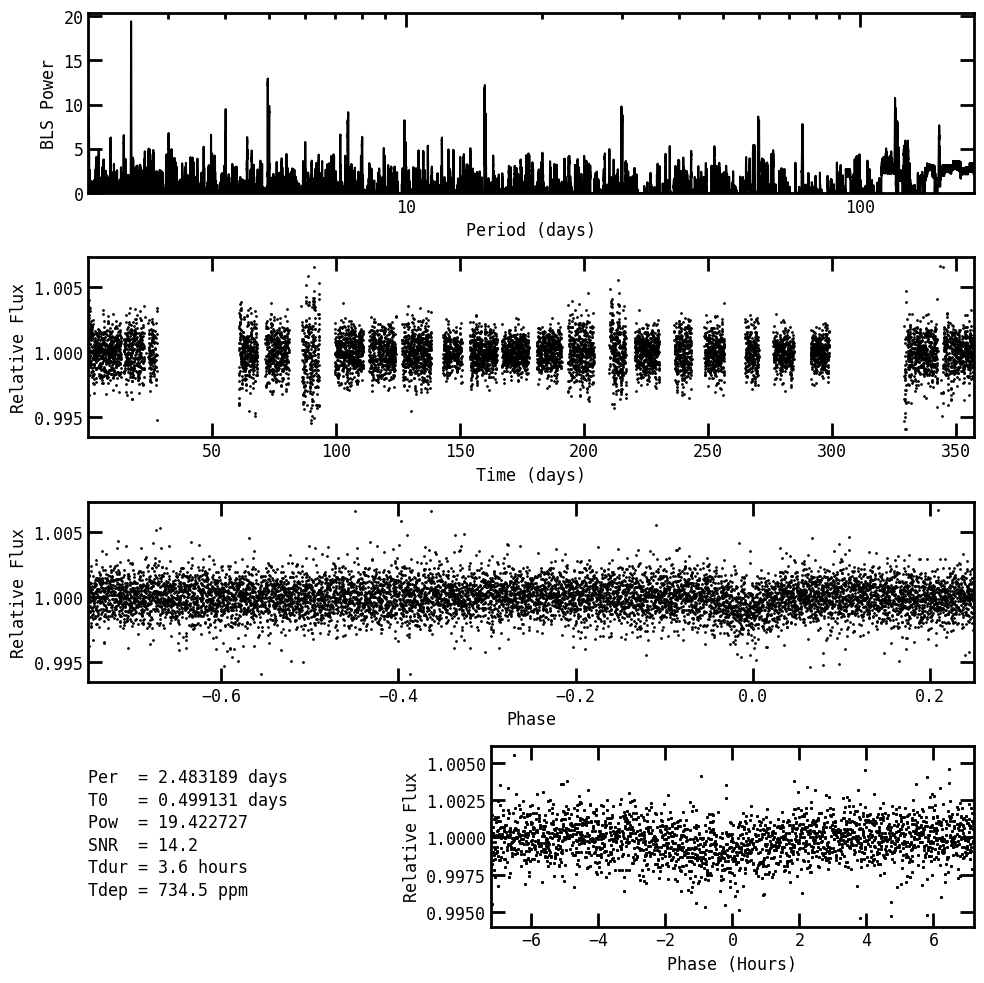

In [7]:
# If you used data processing, use phot.flux_f
# importlib.reload(gbls)
gbls_inputs.freq1 = 2/(np.max(phot.time) - np.min(phot.time))
gbls_inputs.freq2 = 0.5
gbls_ans = gbls.bls(gbls_inputs, phot.time[fstd_flag & (phot.icut == 0)], phot.flux_f[fstd_flag & (phot.icut == 0)])

## Python Transit modelling section

In [24]:
import utils_python.transitmodel as transitm
import utils_python.keplerian as kep
import utils_python.transitfit as transitf
import utils_python.transitplot as transitp
from exotic_ld import StellarLimbDarkening

In [17]:
# Create an initial guess for all 18 parameters
sol = transitm.transit_model_class() # Single planet model has up-to 18-model parameters
sol.rho = kep.rhostar(gbls_ans.bper, gbls_ans.tdur)    # Mean stellar density (g/cm^3)
sol.nl1 = 0.0    # Only used for non-linear limb-darkening
sol.nl2 = 0.0    # Only used for non-linear limb-darkening
sol.dil = 0.0    # dilution
sol.vof = 0.0    # Velocity offset
sol.zpt = 0.0       # Photometric zero point
sol.t0  = [gbls_ans.epo]             # Center of transit time (days)
sol.per = [gbls_ans.bper]            # Orbital Period (days)
sol.bb  = [0.5]                      # Impact parameter
sol.rdr = [np.sqrt(gbls_ans.depth)]  # Rp/R*
sol.ecw = [0.0]  # sqrt(e)cos(w)
sol.esw = [0.0]  # sqrt(e)sin(w)
sol.krv = [0.0]  # RV amplitude (m/s)
sol.ted = [0.0]  # thermal eclipse depth (ppm)
sol.ell = [0.0]  # Ellipsodial variations (ppm)
sol.alb = [0.0]  # Albedo amplitude (ppm)
sol.npl = 1         # Number of planets

# Find Kipping limb-darkening coefficients
M_H = 0.2
Teff = 5400
logg = 4.45

ld_data_path = '/opt/data2/rowe/exotic_ld_data/'  #Remove 'opt' for exo/kona
ld_model = 'mps1'
sld = StellarLimbDarkening(M_H, Teff, logg, ld_model, ld_data_path)
ld, ld_sig = sld.compute_kipping_ld_coeffs(wavelength_range=[0.6*10000, 1.0*10000], mode="TESS", mu_min=0.1, return_sigmas=True)
sol.nl3 = ld[0]
sol.nl4 = ld[1]

In [19]:
phot.ferr = np.full(len(phot.flux_f), np.std(phot.flux_f))
phot.time -= gbls_inputs.zerotime

In [42]:
phot.flux = np.copy(phot.flux_f)

In [36]:
# Define the parameters to fit
params_to_fit = ["rho", "zpt", "t0", "per", "bb", "rdr"]

# Fit the data
sol_fit = transitf.fitTransitModel(sol, params_to_fit, phot)

In [37]:
# Plotting
transitp.printParams(sol_fit)

ρ* (g/cm³):                     0.1489798 ± 3.6165251
c1:                                   0.0 ± 0.0
c2:                                   0.0 ± 0.0
q1:                             0.3545084 ± 0.0000000
q2:                             0.3205229 ± 0.0000000
Dilution:                             0.0 ± 0.0
Velocity Offset:                      0.0 ± 0.0
Photometric zero point:         7.545e-05 ± 2.341e-05
t0 (days):                      0.4556916 ± 0.0118412
Period (days):                  2.4834617 ± 0.0001456
Impact parameter:               0.6067077 ± 9.2386662
Rp/R*:                          0.0283101 ± 0.0518272
sqrt(e)cos(w):                        0.0 ± 0.0
sqrt(e)sin(w):                        0.0 ± 0.0
RV Amplitude (m/s):                   0.0 ± 0.0
Thermal eclipse depth (ppm):          0.0 ± 0.0
Ellipsoidal variations (ppm):         0.0 ± 0.0
Albedo amplitude (ppm):               0.0 ± 0.0


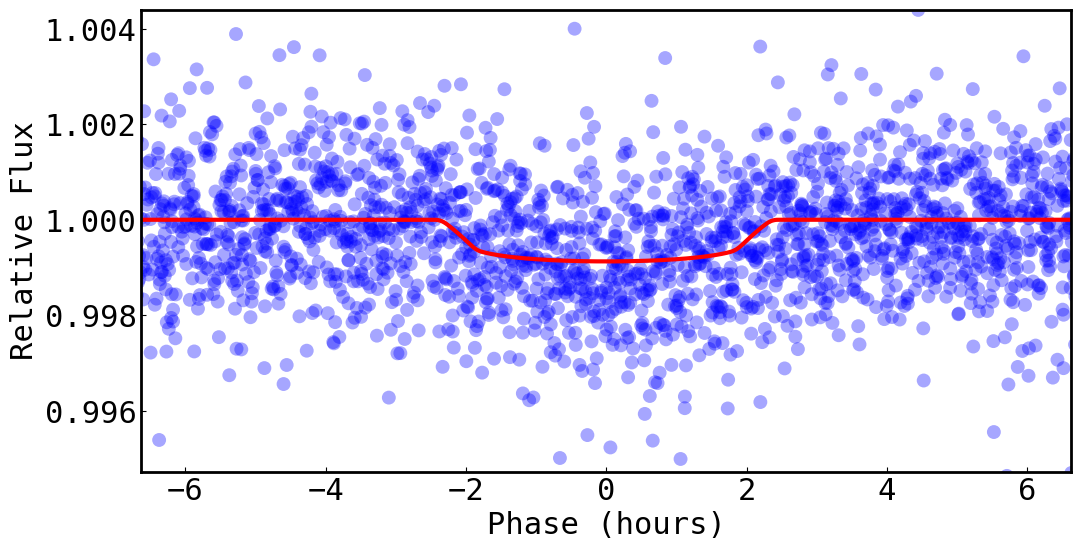

In [38]:
pl_plot = 1
transitp.plotTransit(phot, sol_fit, pl_to_plot=pl_plot)

## MCMC

In [47]:
import utils_python.transitmcmc as tmcmc

In [48]:
nsteps1 = 10000 #total length of chain will be nwalkers*nsteps
nsteps2 = 50000#200000 #nstep1 is to check that MCMC is okay, nstep2 is the real work.
nsteps_inc = 50000#100000
burninf=0.5 #burn-in for evalulating convergence
niter_cor=5000
burnin_cor=1000
nthin=101
nloopmax=5
converge_crit=1.02 #Convergence criteria
buf_converge_crit=1.2 #Convergence criteria for buffer

In [49]:
# Bring up the data to have median around 1
# phot.flux += 1
if np.rint(np.median(phot.flux)) != 1:
    raise ValueError

# Generate input for mcmc
lnprob, x, beta = tmcmc.genmcmcInput(sol_fit, params_to_fit)
sol_a = sol_fit.to_array()
serr = sol_fit.err_to_array()

# Cut out of transit
phot_cut = tmcmc.cutOutOfTransit(sol_fit, phot)

params = [nsteps1, nsteps2, nsteps_inc, burninf, niter_cor, burnin_cor, nthin, nloopmax, converge_crit, buf_converge_crit]

In [52]:
chain, accept, burnin = tmcmc.demcmcRoutine(x, beta, phot_cut, sol_a, serr, params, lnprob)

runtest: [0.02378323 0.00842323 0.00030046 0.00010877]
Current Acceptance:  [0.01267829 0.77849117 0.53216374 0.56065089 0.02263083 0.02332362]
Current Acceptance:  [0.0523338  0.48847926 0.37957317 0.35097493 0.06557377 0.08721805]
Current Acceptance:  [0.19466248 0.19883041 0.22720478 0.21060842 0.25183016 0.26984127]
Current Acceptance:  [0.36111111 0.12643678 0.22720478 0.1761194  0.25183016 0.26984127]
Current Acceptance:  [0.43731343 0.12195122 0.22720478 0.18614719 0.25183016 0.26984127]
Current Acceptance:  [0.3940678  0.19139466 0.22720478 0.23502994 0.25183016 0.26984127]
Current Acceptance:  [0.30387597 0.25516224 0.22720478 0.23502994 0.25183016 0.26984127]
Current Acceptance:  [0.20909091 0.25516224 0.22720478 0.23502994 0.25183016 0.26984127]
Current Acceptance:  [0.17018072 0.25516224 0.22720478 0.23502994 0.25183016 0.26984127]
Current Acceptance:  [0.17937853 0.25516224 0.22720478 0.23502994 0.25183016 0.26984127]
Current Acceptance:  [0.21353383 0.25516224 0.22720478 

In [53]:
# print(output.stdout)

In [54]:
plt.rcParams['font.size'] = 10
mcmc.triplot(chain, burnin, label, color, 30)

NameError: name 'plt' is not defined

In [ ]:
sol_mcmc = tmcmc.getParams(chain, burnin, sol, params_to_fit)
transitp.printParams(sol_mcmc)

In [ ]:
pl_plot = 1

transitp.plotTransit(phot, sol_mcmc, pl_to_plot=pl_plot)

## Old Fortran based code

## Transit Modelling Section 

Note: in the utils folder run the following

`f2py -c tfit5.pyf transitmodel.f keplerian.f ttcor.f occultquad.f mandelagol.f rqsort.f transitdur.f -lgomp --f90flags='-fopenmp' --f77flags='-fopenmp'`  
  
`f2py -c fittransitmodel3.pyf precision.f90 fittermod.f90 fittransitmodel3.f90 getrhosig.f minpack.f transitmodel.f occultquad.f keplerian.f mandelagol.f ttcor.f -lgomp --f90flags='-fopenmp' --f77flags='-fopenmp'`  

and then copy (or move) the created `.so` files to the main code folder.

In [24]:
import transitfit5 as tf5 # will only load if the .so files are present (tfit5 and fittransitmodel.so
import utils_python.transitmodel as transitm
import utils_python.transitfit as transitf
import utils_python.transitplot as transitp
import matplotlib.pyplot as plt
import importlib
import time

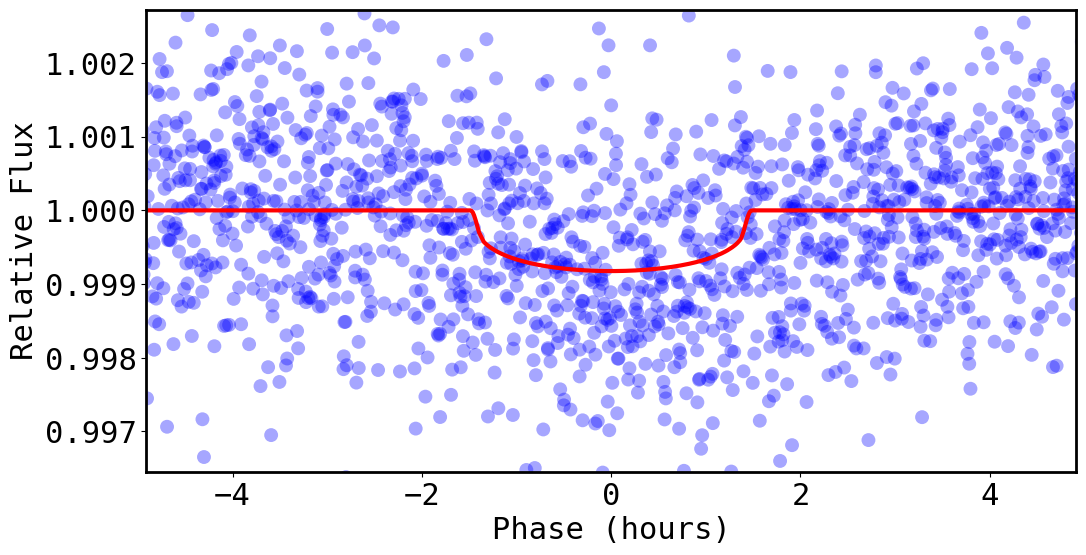

In [12]:
# A basic transit model

bper = 2.483415
epo = 0.44982
rp_rs = 0.0263

sol = np.zeros(18) # single planet model has up-to 18-model parameters

sol[0]  = 0.6  # Mean stellar density (g/cm^3)
sol[1]  = 0.0  # Only used for non-linear limb-darkening
sol[2]  = 0.0  # Only used for non-linear limb-darkening
sol[3]  = 0.6  # q1 (limb-darkening)
sol[4]  = 0.4  # q2 (limb-darkening)
sol[5]  = 0.0  # dilution
sol[6]  = 0.0  # Velocity offset
sol[7]  = 0.0  # photometric zero point
sol[8]  = epo            # Center of transit time (days)
sol[9]  = bper           # Orbital Period (days)
sol[10] = 0.5                    # Impact parameter
sol[11] = rp_rs # Rp/R*
sol[12] = 0.0  # sqrt(e)cos(w)
sol[13] = 0.0  # sqrt(e)sin(w)
sol[14] = 0.0  # RV amplitude (m/s)
sol[15] = 0.0  # thermal eclipse depth (ppm)
sol[16] = 0.0  # Ellipsodial variations (ppm)
sol[17] = 0.0  # Albedo amplitude (ppm)
tf5.transitplot(phot.time - gbls_inputs.zerotime, phot.flux + 1, sol, itime = phot.itime)

ρ (g/cm³):                      0.5144039
c1:                                   0.0
c2:                                   0.0
q1:                                   0.6
q2:                                   0.4
Dilution:                             0.0
Velocity Offset:                      0.0
Photometric zero point:         2.422e-05
t0 (days):                      0.4446551
Period (days):                  2.4835763
Impact parameter:               0.5477459
Rp/R*:                          0.0286011
sqrt(e)cos(w):                        0.0
sqrt(e)sin(w):                        0.0
RV Amplitude (m/s):                   0.0
Thermal eclipse depth (ppm):          0.0
Ellipsoidal variations (ppm):         0.0
Albedo amplitude (ppm):               0.0


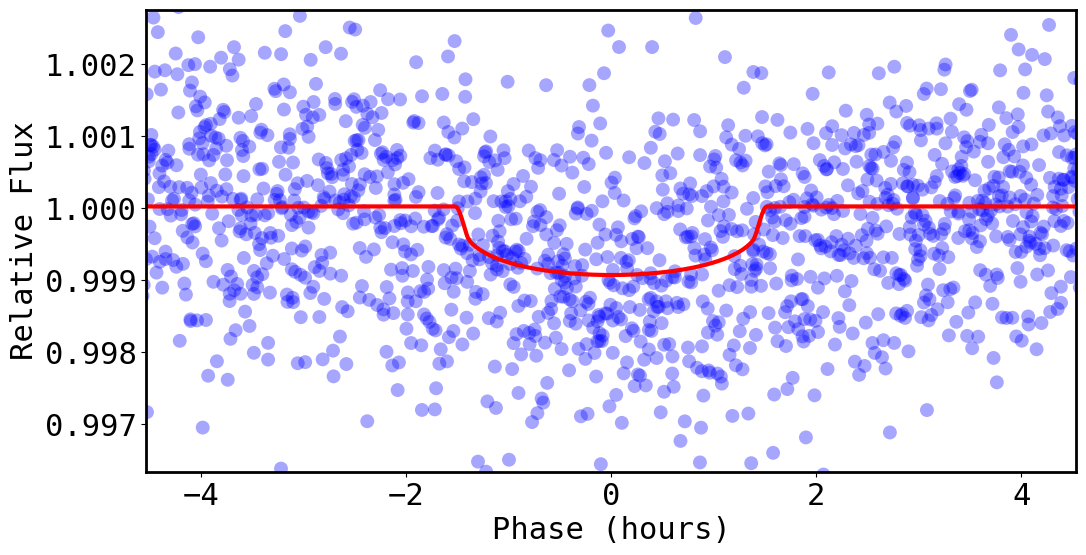

In [89]:
importlib.reload(transitf)
importlib.reload(transitp)

time_a = phot.time - gbls_inputs.zerotime
# transitp.plotTransit(time_a, phot.flux+1, sol, phot.itime)

sol_fit = transitf.fitFromBLS(gbls_ans, time_a, phot.flux + 1, 1, phot.itime)
transitp.printParams(sol_fit)
transitp.plotTransit(time_a, phot.flux + 1, sol_fit, phot.itime)

In [18]:
# Python vs fortran
importlib.reload(transitm)

# import numba
# numba.set_num_threads(48)

transitm.transitModel(sol, phot.time, phot.itime)

print("Python time:")
%timeit transitm.transitModel(sol, phot.time, phot.itime)
print("Fortran time:")
%timeit tf5.transitmodel(sol, phot.time, itime = phot.itime)

Python time:
106 ms ± 3.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Fortran time:
59.5 ms ± 6.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
# Python vs fortran. More points
importlib.reload(transitm)

n = int(1e6)

t_min = min(phot.time)
t_max = max(phot.time)
time_a = np.linspace(t_min, t_max, n)
itime = np.full(n, phot.itime[0])

transitm.transitModel(sol, time_a, itime)

print("Python time:")
%timeit transitm.transitModel(sol, time_a, itime)
print("Fortran time:")
%timeit tf5.transitmodel(sol, time_a, itime = itime)

Python time:
1.28 s ± 57.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Fortran time:
1.49 s ± 163 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
